In [33]:
import tensorflow as tf
import numpy as np
import PIL
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [ ]:
# necessary for using the google collab together with the images dataset

from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# prefix = "./drive/MyDrive/ML_DATA/deforestation"
prefix = "."

In [7]:
# load images



## training
training_images_list = os.listdir(r"{}/data/training/images/".format(prefix))
training_masks_list = []
training_images = []
for n in training_images_list:
  im = PIL.Image.open(r"{}/data/training/images/{}".format(prefix, n))
  training_images.append(im)
  training_masks_list.append(n[:-5]+'.png')

## trainging masks
training_masks = []
for n in training_masks_list:
  im = PIL.Image.open(r"{}/data/training/masks/{}".format(prefix, n))
  training_masks.append(im)

## validation
validation_images_list = os.listdir(r"{}/data/validation/images/".format(prefix))
validation_masks_list = []
validation_images = []
for n in validation_images_list:
  im = PIL.Image.open(r"{}/data/validation/images/{}".format(prefix, n))
  validation_images.append(im)
  validation_masks_list.append(n[:-5]+'.png')

## validation masks
validation_masks = []
for n in validation_masks_list:
  im = PIL.Image.open(r"{}/data/validation/masks/{}".format(prefix, n))
  validation_masks.append(im)

## testing
test_images_list = os.listdir(r"{}/data/test/".format(prefix))
test_images = []
for n in test_images_list:
  im = PIL.Image.open(r"{}/data/test/{}".format(prefix, n))
  test_images.append(im)


In [8]:
for i in range(len(training_images)):
  training_images[i] = np.array(training_images[i])/255
  training_images[i] = training_images[i].reshape(512,512,3)
  training_images[i] = training_images[i].astype('float32')

for i in range(len(training_masks)):
  training_masks[i] = (np.array(training_masks[i])-1)
  training_masks[i] = training_masks[i][:512,:512]
  training_masks[i] = training_masks[i].reshape(512,512,1)
  training_masks[i] = training_masks[i].astype('int')

for i in range(len(validation_images)):
  validation_images[i] = np.array(validation_images[i])/255
  validation_images[i] = validation_images[i].reshape(1,512,512,3)
  validation_images[i] = validation_images[i].astype('float32')

for i in range(len(validation_masks)):
  validation_masks[i] = np.array(validation_masks[i])-1
  validation_masks[i] = validation_masks[i][:512,:512]
  validation_masks[i] = validation_masks[i].reshape(1,512,512,1)
  validation_masks[i] = validation_masks[i].astype('int')

for i in range(len(test_images)):
  test_images[i] = np.array(test_images[i])/255
  test_images[i] = test_images[i].reshape(1,512,512,3)
  test_images[i] = test_images[i].astype('float32')

for i in range(75,90):
  validation_images.append(training_images[i])
  validation_masks.append(training_masks[i])

training_images = training_images[0:75]
training_masks = training_masks[0:75]

In [9]:
training_images = np.array(training_images)
training_masks = np.array(training_masks)

validation_images = np.array(validation_images)
validation_masks = np.array(validation_masks)

C:\Users\radum\AppData\Local\Temp\ipykernel_8812\4161211130.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  validation_images = np.array(validation_images)
C:\Users\radum\AppData\Local\Temp\ipykernel_8812\4161211130.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  validation_masks = np.array(validation_masks)


In [3]:
def learning_curve(model_fit, key='acc', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(model_fit.history[key])
    plt.plot(model_fit.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'test'], loc='best')
    plt.show()

In [62]:
def reconstruct_image(model, image):
    predicted = model.predict(image)
    predicted = np.where(predicted > 0.8, 1, 0)
    predicted = (predicted + 1) % 2
    mask_image = Image.fromarray(predicted[0, :, :, 0] * 255)

    return mask_image

def reconstruct_image_array(model, images):
    predicted = model.predict(images).reshape(512, 512)

    predicted = np.where(predicted > 0.8, 1, 0)
    predicted = (predicted + 1) % 2

    return predicted # Returns array


def score_eval(model, image, mask):
    if type(image) != list:   
        predicted = model.predict(image).reshape(512, 512)
        predicted = np.where(predicted > 0.8, 1, 0)
        predicted = (predicted + 1) % 2
        predicted = predicted.flatten()

        return accuracy_score(mask.flatten(), predicted)

    else:
        scores = []
        for i in range(len(image)):
            predicted = model.predict(image[i])
            predicted = np.where(predicted > 0.8, 1, 0)
            predicted = (predicted + 1) % 2
            predicted = predicted.flatten()

            scores.append(accuracy_score(mask[i].flatten(), predicted))

        return scores


### Simple conv net

In [36]:
cnet_model = tf.keras.models.load_model(r"{}/models/custom-model/model".format(prefix))
cnet_model.summary()

print(cnet_model.history)
# learning_curve(cnet_model, key='loss', ylim=(0, 1))

metrics = cnet_model.evaluate(np.asarray(validation_images[0]), np.asarray(validation_masks[0]), batch_size=8)

print('Validation loss:', metrics[0])
print('Validation accuracy:', metrics[1])

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 512, 512, 32  896         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 256, 256, 32  0          ['conv2d_20[0][0]']              
                                )                                                           

1/1 [==============================] - 0s 169ms/step
[[[[0.8253303 ]
   [0.8318372 ]
   [0.9340263 ]
   ...
   [0.72680855]
   [0.6282545 ]
   [0.63403034]]

  [[0.8316915 ]
   [0.8427845 ]
   [0.93876284]
   ...
   [0.7376936 ]
   [0.6409653 ]
   [0.63599825]]

  [[0.9111412 ]
   [0.9172661 ]
   [0.9827541 ]
   ...
   [0.83880943]
   [0.7296946 ]
   [0.72362095]]

  ...

  [[0.32195905]
   [0.32954997]
   [0.24018683]
   ...
   [0.86824405]
   [0.7346911 ]
   [0.7319929 ]]

  [[0.37826422]
   [0.3863662 ]
   [0.31780797]
   ...
   [0.75509924]
   [0.64793974]
   [0.64510715]]

  [[0.3731124 ]
   [0.37485635]
   [0.30751407]
   ...
   [0.74687016]
   [0.63668513]
   [0.6361543 ]]]]
[[[[1]
   [1]
   [1]
   ...
   [0]
   [0]
   [0]]

  [[1]
   [1]
   [1]
   ...
   [0]
   [0]
   [0]]

  [[1]
   [1]
   [1]
   ...
   [1]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [1]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0

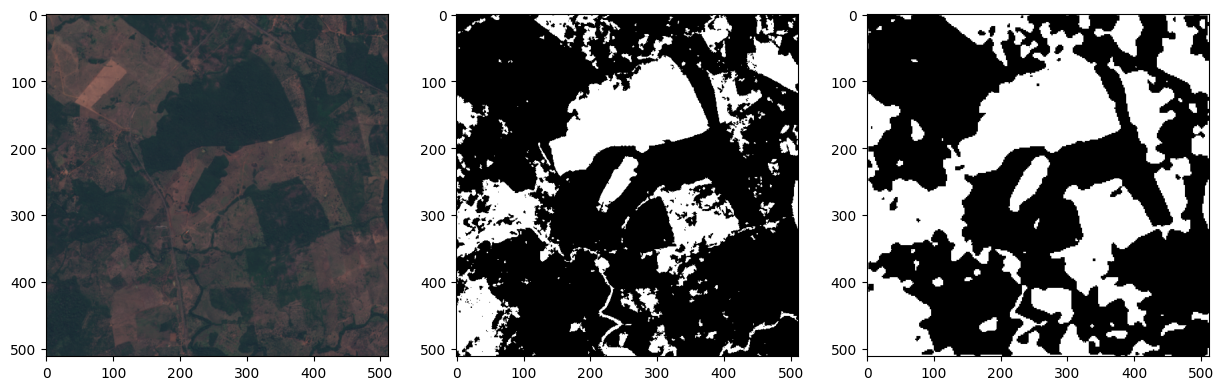

In [42]:
image = PIL.Image.open(r"{}/data/validation/images/{}".format(prefix, validation_images_list[1]))
mask = PIL.Image.open(r"{}/data/validation/masks/{}".format(prefix, validation_images_list[1][:-5]+'.png'))

mask_image = reconstruct_image(cnet_model, validation_images[1])

fig, axs = plt.subplots(1, 3, figsize=(15,6))
axs[0].imshow(image)
axs[1].imshow(mask, cmap='gray')
axs[2].imshow(mask_image, cmap='gray')


### U-Net

In [45]:
unet_model = tf.keras.models.load_model(r"{}/models/u-net/model/".format(prefix))
unet_model.summary()

print(unet_model.history)
# learning_curve(cnet_model, key='loss', ylim=(0, 1))

metrics = unet_model.evaluate(np.asarray(validation_images[0]), np.asarray(validation_masks[0]), batch_size=8)

print('Validation loss:', metrics[0])
print('Validation accuracy:', metrics[1])

Model: "u_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(1, 512, 512, 3)]   0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (1, 512, 512, 64)    1792        ['input_2[0][0]']                
                                                                                                  
 activation (Activation)        (1, 512, 512, 64)    0           ['conv2d_5[0][0]']               
                                                                                                  
 conv2d_6 (Conv2D)              (1, 512, 512, 64)    36928       ['activation[0][0]']             
                                                                                              

### Seg-Net

In [46]:
segnet_model = tf.keras.models.load_model(r"{}/models/seg-net/model/".format(prefix))
segnet_model.summary()

print(segnet_model.history)
# learning_curve(cnet_model, key='loss', ylim=(0, 1))

metrics = segnet_model.evaluate(np.asarray(validation_images[0]), np.asarray(validation_masks[0]), batch_size=8)

print('Validation loss:', metrics[0])
print('Validation accuracy:', metrics[1])

Model: "seg_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 512, 512, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d_24[0][0]']              
 alization)                     )                                                           

1/1 [==============================] - 2s 2s/step


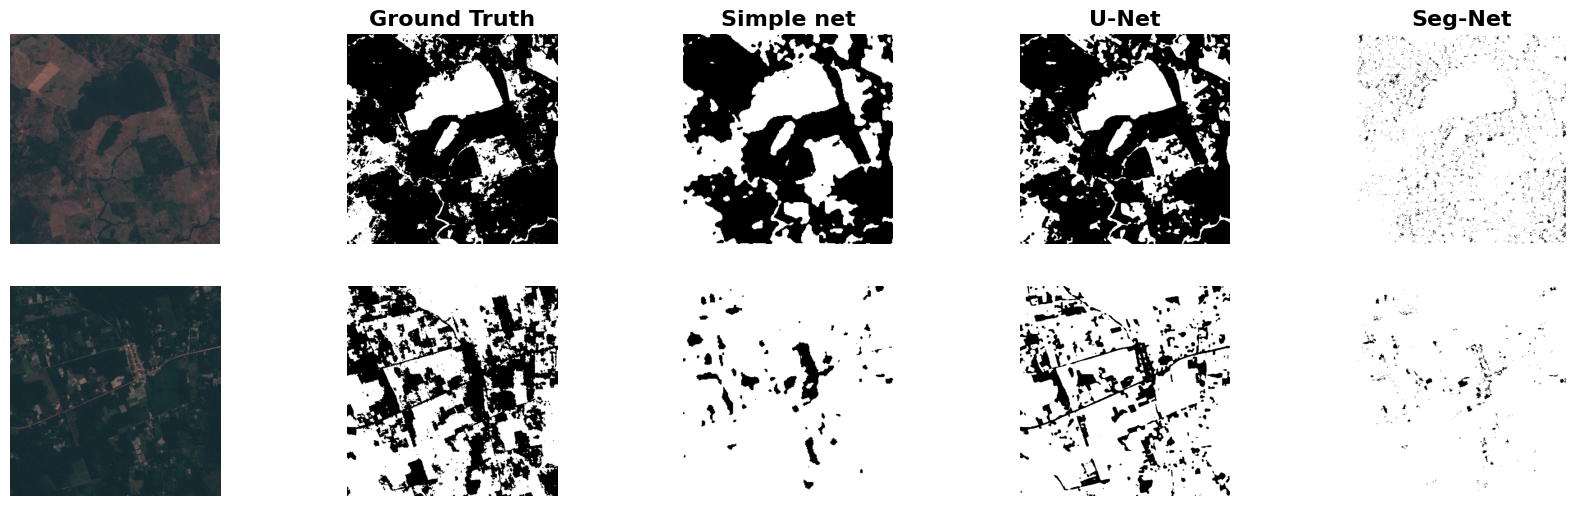

In [96]:
from matplotlib.patches import Circle


mask_image_cnet = reconstruct_image(cnet_model, validation_images[1])
mask_image_unet = reconstruct_image(unet_model, validation_images[1])
mask_image_segnet = reconstruct_image(segnet_model, validation_images[1])
image = PIL.Image.open(r"{}/data/validation/images/{}".format(prefix, validation_images_list[1]))
mask = PIL.Image.open(r"{}/data/validation/masks/{}".format(prefix, validation_images_list[1][:-5]+'.png'))

mask_image_cnet_2 = reconstruct_image(cnet_model, validation_images[2])
mask_image_unet_2 = reconstruct_image(unet_model, validation_images[2])
mask_image_segnet_2 = reconstruct_image(segnet_model, validation_images[2])
image_2 = PIL.Image.open(r"{}/data/validation/images/{}".format(prefix, validation_images_list[2]))
mask_2 = PIL.Image.open(r"{}/data/validation/masks/{}".format(prefix, validation_images_list[2][:-5]+'.png'))

fig, axs = plt.subplots(2, 5, figsize=(21,6))
axs[0, 0].imshow(image)
axs[0, 1].imshow(mask, cmap='gray')
axs[0, 2].imshow(mask_image_cnet, cmap='gray')
axs[0, 3].imshow(mask_image_unet, cmap='gray')
axs[0, 4].imshow(mask_image_segnet, cmap='gray')

axs[1, 0].imshow(image_2)
axs[1, 1].imshow(mask_2, cmap='gray')
axs[1, 2].imshow(mask_image_cnet_2, cmap='gray')
axs[1, 3].imshow(mask_image_unet_2, cmap='gray')
axs[1, 4].imshow(mask_image_segnet_2, cmap='gray')

for i in range(2):
    for j in range(5):
        axs[i][j].axis('off')
        axs[i][j].set_aspect('equal')



# Set titles
axs[0, 1].set_title('Image', size=16, weight="bold")
axs[0, 1].set_title('Ground Truth', size=16, weight="bold")
axs[0, 2].set_title('Simple net', size=16, weight="bold")
axs[0, 3].set_title('U-Net', size=16, weight="bold")
axs[0, 4].set_title('Seg-Net', size=16, weight="bold")


#fig.tight_layout()
fig.subplots_adjust(wspace=0.2, hspace=0.2)
fig.savefig('masks-comparison.pdf', bbox_inches = 'tight', pad_inches = 0.1)

In [69]:
import itertools
from sklearn.metrics import confusion_matrix


predictions_simple = [list(reconstruct_image_array(cnet_model, image).flatten()) for image in validation_images[:5]]
predictions_unet = [list(reconstruct_image_array(unet_model, image).flatten()) for image in validation_images[:5]]
predictions_segnet = [list(reconstruct_image_array(segnet_model, image).flatten()) for image in validation_images[:5]]
actual = [list(mask.flatten()) for mask in validation_masks[:5]]

simple_u   = list(itertools.chain.from_iterable(predictions_simple))
unet_u  = list(itertools.chain.from_iterable(predictions_unet))
segnet_u  = list(itertools.chain.from_iterable(predictions_segnet))
actual_u   = list(itertools.chain.from_iterable(actual))


simple_confmat = confusion_matrix(actual_u, simple_u)
unet_confmat = confusion_matrix(actual_u, unet_u)
segnet_confmat = confusion_matrix(actual_u, segnet_u)

1/1 [==============================] - 2s 2s/step


[[ 13710 352015]
 [640542 304453]]


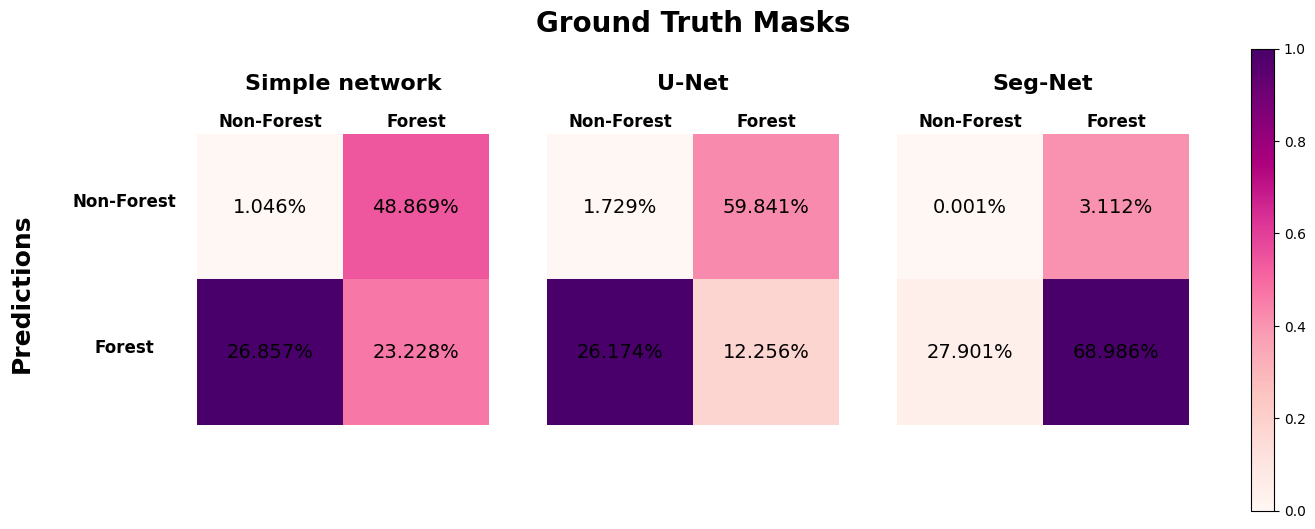

In [89]:
print(simple_confmat)

fig, axs = plt.subplots(1, 3, figsize=(16,6))
axs[0].set_xticks(np.arange(len(['Forest', 'Non-Forest'])))
axs[0].set_yticks(np.arange(len(['Forest', 'Non-Forest'])))

# Set labels of axes
axs[0].set_xticklabels(['Forest', 'Non-Forest'], size=14)
axs[0].set_yticklabels(['Forest', 'Non-Forest'], size=14)

rounding = 3
sz = 14
col = 'black'

for i in range(len(['Forest', 'Non-Forest'])):
    for j in range(len(['Forest', 'Non-Forest'])):
      if i == 0 and j == 0 or i == 1 and j == 1:
        col2 = 'white'
      else:
        col2 = col
        
      text = axs[0].text(i, j, '{}%'.format(np.round(100*simple_confmat[i, j]/simple_confmat.sum(), rounding)),
                      ha="center", va="center", color='black', size=sz)
      
for i in range(len(['Forest', 'Non-Forest'])):
    for j in range(len(['Forest', 'Non-Forest'])):
      if i == 0 and j == 0 or i == 1 and j == 1:
        col2 = 'white'
      else:
        col2 = col
        
      text = axs[1].text(i, j, '{}%'.format(np.round(100*unet_confmat[i, j]/unet_confmat.sum(), rounding)),
                      ha="center", va="center", color='black', size=sz)
        
for i in range(len(['Forest', 'Non-Forest'])):
    for j in range(len(['Forest', 'Non-Forest'])):
      if i == 0 and j == 0:
        col2 = 'white'
      else:
        col2 = col
        
      text = axs[2].text(i, j, '{}%'.format(np.round(100*segnet_confmat[i, j]/segnet_confmat.sum(), rounding)),
                       ha="center", va="center", color='black', size=sz)
      
# Remove axis, adjust spacing
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')

axs[0].set_aspect('equal')
axs[1].set_aspect('equal')
axs[2].set_aspect('equal')

# Add titles
axs[1].text(0.5,1.35, "Ground Truth Masks", size=20, ha="center", 
         transform=axs[1].transAxes, weight="bold")

axs[0].text(0.5,1.15, "Simple network", size=16, ha="center", 
         transform=axs[0].transAxes, weight="bold")

axs[1].text(0.5,1.15, "U-Net", size=16, ha="center", 
         transform=axs[1].transAxes, weight="bold")

axs[2].text(0.5,1.15, "Seg-Net", size=16, ha="center", 
         transform=axs[2].transAxes, weight="bold")

# Plot
tone = 'RdPu'
axs[0].imshow(simple_confmat, cmap=tone)
axs[1].imshow(unet_confmat, cmap=tone)
axs[2].imshow(segnet_confmat, cmap=tone)


axs[0].text(-0.6,0.2, "Predictions", size=18, ha="center", 
         transform=axs[0].transAxes, weight="bold", rotation=90)


# Add left labels
axs[0].text(-0.25,0.75, "Non-Forest", size=12, ha="center", 
         transform=axs[0].transAxes, weight="bold")
axs[0].text(-0.25,0.25, "Forest", size=12, ha="center", 
         transform=axs[0].transAxes, weight="bold")


# Add top labels
axs[0].text(0.25,1.025, "Non-Forest", size=12, ha="center", 
         transform=axs[0].transAxes, weight="bold")
axs[0].text(0.75,1.025, "Forest", size=12, ha="center", 
         transform=axs[0].transAxes, weight="bold")

axs[1].text(0.25,1.025, "Non-Forest", size=12, ha="center", 
         transform=axs[1].transAxes, weight="bold")
axs[1].text(0.75,1.025, "Forest", size=12, ha="center", 
         transform=axs[1].transAxes, weight="bold")

axs[2].text(0.25,1.025, "Non-Forest", size=12, ha="center", 
         transform=axs[2].transAxes, weight="bold")
axs[2].text(0.75,1.025, "Forest", size=12, ha="center", 
         transform=axs[2].transAxes, weight="bold")
      
fig.subplots_adjust(wspace=0.2, hspace=0.2)
fig.colorbar(plt.cm.ScalarMappable(cmap=tone), ax=axs)
fig.savefig('confusion_matrix.pdf', bbox_inches = 'tight', pad_inches = 0.1)